### Antoine EDY
# Natural Language Processing (COMM061) - Coursework

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
import nltk
from torch.utils.tensorboard import SummaryWriter

In [2]:
dataset = load_dataset("surrey-nlp/PLOD-CW")

In [3]:
def the_preprocess(df):
    df = pd.DataFrame(df)
    # make everything lowercase
    #df["tokens"] = df["tokens"].apply(lambda x: [i.lower() for i in x])
    # lematize
    lematizer = nltk.WordNetLemmatizer()
    df["tokens"] = df["tokens"].apply(lambda x: [lematizer.lemmatize(i) for i in x])
    #stemming
    #stemmer = nltk.PorterStemmer()
    #df["tokens"] = df["tokens"].apply(lambda x: [stemmer.stem(i) for i in x])

    return df

train_dataset = the_preprocess(dataset["train"])
test_dataset = the_preprocess(dataset["test"])
val_dataset = the_preprocess(dataset["validation"])

In [4]:
lematizer = nltk.WordNetLemmatizer()
sentence = "The striped bats are hanging on their feet for best"
sentence = sentence.split()
sentence = [lematizer.lemmatize(i) for i in sentence]
print(sentence)

['The', 'striped', 'bat', 'are', 'hanging', 'on', 'their', 'foot', 'for', 'best']


In [5]:
stemmer = nltk.PorterStemmer()
sentence = "The striped bats are hanging on their feet for best"
sentence = sentence.split()
sentence = [lematizer.lemmatize(i) for i in sentence]
sentence = [stemmer.stem(i) for i in sentence]
print(sentence)

['the', 'stripe', 'bat', 'are', 'hang', 'on', 'their', 'foot', 'for', 'best']


In [6]:
TEXT2ID = {
    "B-O": 0,
    "B-AC": 1,
    "PAD": 2,
    "B-LF": 3,
    "I-LF": 4,
}
ID2TEXT = {v: k for k, v in TEXT2ID.items()}

print(f"TEXT2ID: {TEXT2ID}\nID2TEXT: {ID2TEXT}\n")

def preprocess(df):
    df = df.drop(columns=['pos_tags'])
    df = df.rename(columns={"ner_tags": "labels"})
    df["ids"] = df["labels"].apply(lambda x: [TEXT2ID[i] for i in x])
    df["sentences"] = df["tokens"].apply(lambda x: " ".join(x))

    return df


train_dataset = preprocess(train_dataset)
test_dataset = preprocess(test_dataset)
val_dataset = preprocess(val_dataset)

train_dataset.info()


# Here the exploration to add at the end of the work.

TEXT2ID: {'B-O': 0, 'B-AC': 1, 'PAD': 2, 'B-LF': 3, 'I-LF': 4}
ID2TEXT: {0: 'B-O', 1: 'B-AC', 2: 'PAD', 3: 'B-LF', 4: 'I-LF'}

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokens     1072 non-null   object
 1   labels     1072 non-null   object
 2   ids        1072 non-null   object
 3   sentences  1072 non-null   object
dtypes: object(4)
memory usage: 33.6+ KB


In [7]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, trait, were, m...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological trait were measure...
2,"[Minor, H, antigen, alloimmune, response, read...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune response readily oc...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [8]:
# distribution of labels
all_labels = [label for labels in train_dataset["labels"] for label in labels]

In [9]:
# plot the distribution of labels
print(f"Number of labels: {len(all_labels)}")
print(f"Number of unique labels: {len(set(all_labels))}")
print(f"Labels: {set(all_labels)}")

for i in set(all_labels):
    print(f"Number of {i}: {all_labels.count(i)}")

Number of labels: 40000
Number of unique labels: 4
Labels: {'B-LF', 'B-O', 'I-LF', 'B-AC'}
Number of B-LF: 1462
Number of B-O: 32971
Number of I-LF: 3231
Number of B-AC: 2336


In [10]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

1072
126
153


In [11]:
train_dataset.head()

,tokens,labels,ids,sentences
0,"[For, this, purpose, the, Gothenburg, Young, P...","[B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...","[0, 0, 0, 0, 3, 4, 4, 4, 4, 0, 1, 0, 0, 0, 0]",For this purpose the Gothenburg Young Persons ...
1,"[The, following, physiological, trait, were, m...","[B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...","[0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 1, 0, 0, 0, 0, ...",The following physiological trait were measure...
2,"[Minor, H, antigen, alloimmune, response, read...","[B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 0, ...",Minor H antigen alloimmune response readily oc...
3,"[EPI, =, Echo, planar, imaging, .]","[B-AC, B-O, B-LF, I-LF, I-LF, B-O]","[1, 0, 3, 4, 4, 0]",EPI = Echo planar imaging .
4,"[Furthermore, ,, eNOS, -, derived, NO, S, -, n...","[B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O...","[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","Furthermore , eNOS - derived NO S - nitrosylat..."


In [12]:
from torchtext.data import Field, Dataset, Example

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True) # Default behaviour is to tokenize by splitting
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

fields = {
    'sentences': ('text', text_field),
    'ids': ('label', label_field)
}

def read_data(df):
    examples = []
    fields = {'sentence_labels': ('labels', label_field),
              'sentence_tokens': ('text', text_field)}
    
    for i in range(len(df)):
        tokens = df['tokens'][i]
        labels = df['labels'][i]
        
        e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                             fields=fields)
        examples.append(e)
    
    return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])


train_data = read_data(train_dataset)
val_data = read_data(val_dataset)
test_data = read_data(test_dataset)

print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(val_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object at 0x1760d6470>, 'text': <torchtext.data.field.Field object at 0x30bef7e50>}
['For', 'this', 'purpose', 'the', 'Gothenburg', 'Young', 'Persons', 'Empowerment', 'Scale', '(', 'GYPES', ')', 'wa', 'developed', '.']
['B-O', 'B-O', 'B-O', 'B-O', 'B-LF', 'I-LF', 'I-LF', 'I-LF', 'I-LF', 'B-O', 'B-AC', 'B-O', 'B-O', 'B-O', 'B-O']
Train: 1072
Dev: 126
Test: 153


In [13]:
VOCAB_SIZE = 20000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

In [14]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, 
                            sort_key=lambda x: len(x.text), sort_within_batch=True)
val_iter = BucketIterator(dataset=val_data, batch_size=BATCH_SIZE, 
                          sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, 
                           sort_key=lambda x: len(x.text), sort_within_batch=True)

In [15]:
import random
import os
import numpy as np

emb = 'fasttext'

if emb == 'fasttext':

    EMBEDDING_PATH = "/Users/antoineedy/Documents/MScAI/Semester2/NLP/Coursework/code/data/cc.en.300.vec"

    def load_embeddings(path):
        """ Load the FastText embeddings from the embedding file. """
        print("Loading pre-trained embeddings")
        
        embeddings = {}
        with open(path) as i:
            for line in i:
                if len(line) > 2: 
                    line = line.strip().split()
                    word = line[0]
                    embedding = np.array(line[1:])
                    embeddings[word] = embedding
        
        return embeddings
        

    def initialize_embeddings(embeddings, vocabulary):
        """ Use the pre-trained embeddings to initialize an embedding matrix. """
        print("Initializing embedding matrix")
        embedding_size = len(embeddings["."])
        embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                    
        for idx, word in enumerate(vocabulary.itos): 
            if word in embeddings:
                embedding_matrix[idx,:] = embeddings[word]
                
        return embedding_matrix

    embeddings = load_embeddings(EMBEDDING_PATH)
    embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    embedding_matrix = torch.from_numpy(embedding_matrix)
    print(embedding_matrix.shape)

elif emb == 'glove':

    EMBEDDING_PATH = "data/glove.6B.300d.txt"

    def load_embeddings(path):
        """ Load the FastText embeddings from the embedding file. """
        print("Loading pre-trained embeddings")
        
        embeddings = {}
        with open(path) as i:
            for line in i:
                if len(line) > 2: 
                    line = line.strip().split()
                    word = line[0]
                    embedding = np.array(line[1:])
                    embeddings[word] = embedding
        
        return embeddings
        

    def initialize_embeddings(embeddings, vocabulary):
        """ Use the pre-trained embeddings to initialize an embedding matrix. """
        print("Initializing embedding matrix")
        embedding_size = len(embeddings["."])
        embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)
                                    
        for idx, word in enumerate(vocabulary.itos): 
            if word in embeddings:
                embedding_matrix[idx,:] = embeddings[word]
                
        return embedding_matrix

    embeddings = load_embeddings(EMBEDDING_PATH)
    embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
    embedding_matrix = torch.from_numpy(embedding_matrix)
    print(embedding_matrix.shape)


elif emb == 'word2vec':
    import gensim
    model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True)
    em = []
    for word in text_field.vocab.itos:
        if word in model:
            em.append(model.get_vector(word))
        else:
            em.append(np.zeros(300))
    em = np.array(em)
    embedding_matrix = torch.tensor(em, dtype=torch.float32)
    print(embedding_matrix.shape)

Loading pre-trained embeddings
Initializing embedding matrix
torch.Size([8711, 300])


In [16]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits

In [17]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support, classification_report
from seqeval.metrics import f1_score as seqeval_f1_score

def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES}: {label_field.vocab.itos}")

def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    writer = SummaryWriter()

    # add weight to indexes 3, 4, 5
    w = [0, 0, 0.0443, 0.6259, 1.0000, 0.4525]
    class_weights = torch.tensor(w).to(device)
    criterion = nn.CrossEntropyLoss(weight = class_weights, ignore_index=1)  # we mask the <pad> labels
    # Hinge loss
    # criterion = nn.MultiMarginLoss(margin=1.0, weight=class_weights, reduction='mean')
    
    optimizer = optim.Adam(model.parameters())

    # SGD
    #lr = 0.1
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # AdamW
    optimizer = optim.AdamW(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)

        #tensorboard
        writer.add_scalar('train/loss', total_loss, epoch)
        writer.add_scalar('train/precision', train_scores[2], epoch)

        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)

        writer.add_scalar('val/loss', total_loss, epoch)
        writer.add_scalar('val/precision', dev_scores[2], epoch)


        labels = label_field.vocab.itos[2:]
        labels = sorted(labels, key=lambda x: x.split("-")[-1])
        label_idxs = [label_field.vocab.stoi[l] for l in labels]

        cr = classification_report(correct, predictions, labels = label_idxs, target_names=labels, output_dict=True)

        out = {}
        for key in cr.keys():
            if key == 'accuracy':
                out[key] = cr[key]
            else:
                for new_k in ['precision', 'recall', 'f1-score']:
                    out[key+'_'+new_k] = cr[key][new_k]
        
        for (key, value) in out.items():
            writer.add_scalar(f'test/{key}', value, epoch)

        t2id = ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']
        t2id= {i: t2id[i] for i in range(len(t2id))}


        correct = [t2id[i] for i in correct]
        predictions = [t2id[i] for i in predictions]

        # sequeval f1 score
        seqeval_f1 = seqeval_f1_score([correct], [predictions])
        print(seqeval_f1)
        writer.add_scalar('test/seqeval_f1', seqeval_f1, epoch)
        
        
        dev_f = dev_scores[2]

        dev_f = out['macro avg_f1-score']

        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Macro average F1-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Number of classes: 6: ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


In [18]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

In [19]:
import math

EMBEDDING_DIM = 300 #fasttext & word2vec & glove
# EMBEDDING_DIM = 768 #bert
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
print(f"Number of classes: {NUM_CLASSES} : {label_field.vocab.itos}")
MAX_EPOCHS = 70
PATIENCE = 50
OUTPUT_PATH = "model_saves/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  # embeddings
# tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES)  # no embeddings

train_f, dev_f = train(tagger.to(device), train_iter, val_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

Number of classes: 6 : ['<unk>', '<pad>', 'B-O', 'I-LF', 'B-AC', 'B-LF']


Epoch 0: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s]


Total training loss: 41.681060552597046
Training performance: (0.267525, 0.267525, 0.267525, None)
Total development loss: 3.8846705555915833
Development performance: (0.6978, 0.6978, 0.6978, None)
0.7053000618684264
Saving model.


Epoch 1: 100%|██████████| 34/34 [00:05<00:00,  6.67it/s]


Total training loss: 22.121582567691803
Training performance: (0.6881, 0.6881, 0.6881, None)
Total development loss: 2.5240572690963745
Development performance: (0.7964, 0.7964, 0.7964, None)
0.8009728415079044
Saving model.


Epoch 2: 100%|██████████| 34/34 [00:05<00:00,  6.60it/s]


Total training loss: 16.462463855743408
Training performance: (0.780825, 0.780825, 0.780825, None)
Total development loss: 2.3635749220848083
Development performance: (0.757, 0.757, 0.757, None)
0.7624138994551249


Epoch 3: 100%|██████████| 34/34 [00:07<00:00,  4.66it/s]


Total training loss: 14.2469382584095
Training performance: (0.7912, 0.7912, 0.7912, None)
Total development loss: 2.141958564519882
Development performance: (0.8062, 0.8062, 0.8062, None)
0.8092238927265339
Saving model.


Epoch 4: 100%|██████████| 34/34 [00:05<00:00,  5.91it/s]


Total training loss: 12.867154031991959
Training performance: (0.8057, 0.8057, 0.8057, None)
Total development loss: 2.0472545623779297
Development performance: (0.8118, 0.8118, 0.8118, None)
0.8142623620760114
Saving model.


Epoch 5: 100%|██████████| 34/34 [00:05<00:00,  6.15it/s]


Total training loss: 11.622651547193527
Training performance: (0.825875, 0.825875, 0.825875, None)
Total development loss: 2.1740987598896027
Development performance: (0.8702, 0.8702, 0.8702, None)
0.8727162612294338
Saving model.


Epoch 6: 100%|██████████| 34/34 [00:05<00:00,  5.81it/s]


Total training loss: 10.712860822677612
Training performance: (0.832475, 0.832475, 0.832475, None)
Total development loss: 1.8778501451015472
Development performance: (0.8298, 0.8298, 0.8298, None)
0.8308255388369256


Epoch 7: 100%|██████████| 34/34 [00:05<00:00,  5.95it/s]


Total training loss: 10.20322473347187
Training performance: (0.830925, 0.830925, 0.830925, None)
Total development loss: 2.134759098291397
Development performance: (0.8946, 0.8946, 0.8946, None)
0.8965795580667945
Saving model.


Epoch 8: 100%|██████████| 34/34 [00:05<00:00,  6.08it/s]


Total training loss: 10.04070945084095
Training performance: (0.845075, 0.845075, 0.845075, None)
Total development loss: 1.87765833735466
Development performance: (0.8356, 0.8356, 0.8356, None)
0.8386965790275099


Epoch 9: 100%|██████████| 34/34 [00:05<00:00,  6.22it/s]


Total training loss: 8.898783683776855
Training performance: (0.854175, 0.854175, 0.854175, None)
Total development loss: 1.8767363131046295
Development performance: (0.851, 0.851, 0.851, None)
0.8529591214154972


Epoch 10: 100%|██████████| 34/34 [00:05<00:00,  6.03it/s]


Total training loss: 8.353291928768158
Training performance: (0.85805, 0.85805, 0.85805, None)
Total development loss: 1.893040508031845
Development performance: (0.87, 0.87, 0.87, None)
0.8733677497722443


Epoch 11: 100%|██████████| 34/34 [00:05<00:00,  6.11it/s]


Total training loss: 7.805068880319595
Training performance: (0.86765, 0.86765, 0.86765, None)
Total development loss: 1.7988835871219635
Development performance: (0.8424, 0.8424, 0.8424, None)
0.8460758466842424


Epoch 12: 100%|██████████| 34/34 [00:05<00:00,  6.12it/s]


Total training loss: 7.358078688383102
Training performance: (0.872425, 0.872425, 0.872425, None)
Total development loss: 1.9349627494812012
Development performance: (0.8064, 0.8064, 0.8064, None)
0.8098598752173468


Epoch 13: 100%|██████████| 34/34 [00:06<00:00,  5.07it/s]


Total training loss: 7.022028848528862
Training performance: (0.874025, 0.874025, 0.874025, None)
Total development loss: 1.7299894988536835
Development performance: (0.826, 0.826, 0.826, None)
0.827998379254457


Epoch 14: 100%|██████████| 34/34 [00:05<00:00,  5.85it/s]


Total training loss: 6.384292080998421
Training performance: (0.887375, 0.887375, 0.887375, None)
Total development loss: 1.8119201064109802
Development performance: (0.8604, 0.8604, 0.8604, None)
0.8629832017810161


Epoch 15: 100%|██████████| 34/34 [00:05<00:00,  5.92it/s]


Total training loss: 6.071491666138172
Training performance: (0.893075, 0.893075, 0.893075, None)
Total development loss: 1.7423635721206665
Development performance: (0.8474, 0.8474, 0.8474, None)
0.8489820723184441


Epoch 16: 100%|██████████| 34/34 [00:06<00:00,  5.66it/s]


Total training loss: 5.6805156618356705
Training performance: (0.897575, 0.897575, 0.897575, None)
Total development loss: 1.894538700580597
Development performance: (0.8796, 0.8796, 0.8796, None)
0.8830196316535114


Epoch 17: 100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


Total training loss: 5.1753774508833885
Training performance: (0.9026, 0.9026, 0.9026, None)
Total development loss: 1.898715317249298
Development performance: (0.8634, 0.8634, 0.8634, None)
0.8657079197893458


Epoch 18: 100%|██████████| 34/34 [00:06<00:00,  5.31it/s]


Total training loss: 4.973257876932621
Training performance: (0.907875, 0.907875, 0.907875, None)
Total development loss: 2.24480402469635
Development performance: (0.88, 0.88, 0.88, None)
0.8824959481361426


Epoch 19: 100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


Total training loss: 4.727583073079586
Training performance: (0.91275, 0.91275, 0.91275, None)
Total development loss: 2.075860410928726
Development performance: (0.8606, 0.8606, 0.8606, None)
0.8621248986212491


Epoch 20: 100%|██████████| 34/34 [00:04<00:00,  6.85it/s]


Total training loss: 4.125961758196354
Training performance: (0.918225, 0.918225, 0.918225, None)
Total development loss: 2.140803635120392
Development performance: (0.8494, 0.8494, 0.8494, None)
0.852449041679343


Epoch 21: 100%|██████████| 34/34 [00:05<00:00,  6.55it/s]


Total training loss: 3.8590009212493896
Training performance: (0.922475, 0.922475, 0.922475, None)
Total development loss: 2.3291521966457367
Development performance: (0.8928, 0.8928, 0.8928, None)
0.8955977382875606


Epoch 22: 100%|██████████| 34/34 [00:05<00:00,  6.53it/s]


Total training loss: 3.4817947670817375
Training performance: (0.9316, 0.9316, 0.9316, None)
Total development loss: 2.521644800901413
Development performance: (0.905, 0.905, 0.905, None)
0.9070331447049313
Saving model.


Epoch 23: 100%|██████████| 34/34 [00:05<00:00,  5.82it/s]


Total training loss: 3.1848374903202057
Training performance: (0.934, 0.934, 0.934, None)
Total development loss: 2.379627048969269
Development performance: (0.8892, 0.8892, 0.8892, None)
0.8902611864749949


Epoch 24: 100%|██████████| 34/34 [00:04<00:00,  6.86it/s]


Total training loss: 3.0508559085428715
Training performance: (0.941075, 0.941075, 0.941075, None)
Total development loss: 2.2736799120903015
Development performance: (0.8856, 0.8856, 0.8856, None)
0.8875429032909349


Epoch 25: 100%|██████████| 34/34 [00:05<00:00,  6.62it/s]


Total training loss: 2.7295382246375084
Training performance: (0.940725, 0.940725, 0.940725, None)
Total development loss: 2.1034477949142456
Development performance: (0.8556, 0.8556, 0.8556, None)
0.8568534089757877


Epoch 26: 100%|██████████| 34/34 [00:04<00:00,  7.43it/s]


Total training loss: 2.62605844438076
Training performance: (0.939125, 0.939125, 0.939125, None)
Total development loss: 2.424968719482422
Development performance: (0.8904, 0.8904, 0.8904, None)
0.8916927425052992


Epoch 27: 100%|██████████| 34/34 [00:04<00:00,  7.80it/s]


Total training loss: 2.4763612151145935
Training performance: (0.9462, 0.9462, 0.9462, None)
Total development loss: 2.4856720864772797
Development performance: (0.8798, 0.8798, 0.8798, None)
0.8826623507991099


Epoch 28: 100%|██████████| 34/34 [00:04<00:00,  7.64it/s]


Total training loss: 2.2237343303859234
Training performance: (0.94985, 0.94985, 0.94985, None)
Total development loss: 2.293545812368393
Development performance: (0.8702, 0.8702, 0.8702, None)
0.8713231577883352


Epoch 29: 100%|██████████| 34/34 [00:04<00:00,  7.09it/s]


Total training loss: 2.255358813330531
Training performance: (0.95, 0.95, 0.95, None)
Total development loss: 3.0530121326446533
Development performance: (0.9112, 0.9112, 0.9112, None)
0.9132189707366297
Saving model.


Epoch 30: 100%|██████████| 34/34 [00:04<00:00,  7.52it/s]


Total training loss: 1.982375379651785
Training performance: (0.955275, 0.955275, 0.955275, None)
Total development loss: 3.0594310760498047
Development performance: (0.9, 0.9, 0.9, None)
0.9029714978775015


Epoch 31: 100%|██████████| 34/34 [00:04<00:00,  7.12it/s]


Total training loss: 1.7690251395106316
Training performance: (0.959925, 0.959925, 0.959925, None)
Total development loss: 2.834263861179352
Development performance: (0.8988, 0.8988, 0.8988, None)
0.9012145748987854


Epoch 32: 100%|██████████| 34/34 [00:04<00:00,  7.17it/s]


Total training loss: 1.8423053491860628
Training performance: (0.953125, 0.953125, 0.953125, None)
Total development loss: 3.0929524302482605
Development performance: (0.9022, 0.9022, 0.9022, None)
0.905770782889427


Epoch 33: 100%|██████████| 34/34 [00:04<00:00,  7.33it/s]


Total training loss: 1.803859457373619
Training performance: (0.957775, 0.957775, 0.957775, None)
Total development loss: 2.871930181980133
Development performance: (0.8904, 0.8904, 0.8904, None)
0.8932215375290433


Epoch 34: 100%|██████████| 34/34 [00:04<00:00,  7.65it/s]


Total training loss: 1.7904788386076689
Training performance: (0.957225, 0.957225, 0.957225, None)
Total development loss: 2.9139504730701447
Development performance: (0.9042, 0.9042, 0.9042, None)
0.9077155824508321


Epoch 35: 100%|██████████| 34/34 [00:04<00:00,  7.65it/s]


Total training loss: 1.5050229150801897
Training performance: (0.9638, 0.9638, 0.9638, None)
Total development loss: 3.0296865105628967
Development performance: (0.895, 0.895, 0.895, None)
0.8971792538671519


Epoch 36: 100%|██████████| 34/34 [00:04<00:00,  6.89it/s]


Total training loss: 1.3479828229174018
Training performance: (0.967025, 0.967025, 0.967025, None)
Total development loss: 3.9942741990089417
Development performance: (0.911, 0.911, 0.911, None)
0.912029087970912


Epoch 37: 100%|██████████| 34/34 [00:05<00:00,  6.38it/s]


Total training loss: 1.161216538399458
Training performance: (0.9731, 0.9731, 0.9731, None)
Total development loss: 3.509943664073944
Development performance: (0.9004, 0.9004, 0.9004, None)
0.9018894614529656


Epoch 38: 100%|██████████| 34/34 [00:05<00:00,  6.37it/s]


Total training loss: 1.0399597361683846
Training performance: (0.974175, 0.974175, 0.974175, None)
Total development loss: 3.930672287940979
Development performance: (0.9062, 0.9062, 0.9062, None)
0.9076426698931236


Epoch 39: 100%|██████████| 34/34 [00:05<00:00,  6.11it/s]


Total training loss: 0.902461557649076
Training performance: (0.977425, 0.977425, 0.977425, None)
Total development loss: 4.138614535331726
Development performance: (0.9102, 0.9102, 0.9102, None)
0.9106674732809034


Epoch 40: 100%|██████████| 34/34 [00:05<00:00,  6.57it/s]


Total training loss: 0.8685055654495955
Training performance: (0.9785, 0.9785, 0.9785, None)
Total development loss: 3.9392729997634888
Development performance: (0.9046, 0.9046, 0.9046, None)
0.9076224129227664


Epoch 41: 100%|██████████| 34/34 [00:05<00:00,  6.59it/s]


Total training loss: 0.7333069071173668
Training performance: (0.982, 0.982, 0.982, None)
Total development loss: 4.242374420166016
Development performance: (0.9038, 0.9038, 0.9038, None)
0.9069814366424536


Epoch 42: 100%|██████████| 34/34 [00:06<00:00,  5.43it/s]


Total training loss: 0.8985772393643856
Training performance: (0.9771, 0.9771, 0.9771, None)
Total development loss: 3.7183289527893066
Development performance: (0.9042, 0.9042, 0.9042, None)
0.9061932620536616


Epoch 43: 100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


Total training loss: 2.2322655683383346
Training performance: (0.948175, 0.948175, 0.948175, None)
Total development loss: 2.7940717935562134
Development performance: (0.884, 0.884, 0.884, None)
0.884483107424641


Epoch 44: 100%|██████████| 34/34 [00:05<00:00,  6.25it/s]


Total training loss: 1.53855412453413
Training performance: (0.96485, 0.96485, 0.96485, None)
Total development loss: 3.3213562965393066
Development performance: (0.8954, 0.8954, 0.8954, None)
0.8969844161100992


Epoch 45: 100%|██████████| 34/34 [00:05<00:00,  6.21it/s]


Total training loss: 1.056081397458911
Training performance: (0.97255, 0.97255, 0.97255, None)
Total development loss: 4.108601152896881
Development performance: (0.9038, 0.9038, 0.9038, None)
0.9052950075642964


Epoch 46: 100%|██████████| 34/34 [00:05<00:00,  6.04it/s]


Total training loss: 0.7943324223160744
Training performance: (0.9803, 0.9803, 0.9803, None)
Total development loss: 3.981302499771118
Development performance: (0.9012, 0.9012, 0.9012, None)
0.9028225806451613


Epoch 47: 100%|██████████| 34/34 [00:05<00:00,  6.14it/s]


Total training loss: 0.6271514459513128
Training performance: (0.9836, 0.9836, 0.9836, None)
Total development loss: 4.522134482860565
Development performance: (0.9078, 0.9078, 0.9078, None)
0.9093844601412714


Epoch 48: 100%|██████████| 34/34 [00:05<00:00,  6.24it/s]


Total training loss: 0.5318172206170857
Training performance: (0.986475, 0.986475, 0.986475, None)
Total development loss: 4.485099673271179
Development performance: (0.9078, 0.9078, 0.9078, None)
0.9101917255297679


Epoch 49: 100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


Total training loss: 0.5599563820287585
Training performance: (0.98595, 0.98595, 0.98595, None)
Total development loss: 4.581151068210602
Development performance: (0.9038, 0.9038, 0.9038, None)
0.9055387713997985


Epoch 50: 100%|██████████| 34/34 [00:05<00:00,  5.78it/s]


Total training loss: 0.5244255368597806
Training performance: (0.9865, 0.9865, 0.9865, None)
Total development loss: 5.566702365875244
Development performance: (0.91, 0.91, 0.91, None)
0.9110169491525425


Epoch 51: 100%|██████████| 34/34 [00:06<00:00,  5.47it/s]


Total training loss: 0.3999288387130946
Training performance: (0.99025, 0.99025, 0.99025, None)
Total development loss: 5.788962960243225
Development performance: (0.9146, 0.9146, 0.9146, None)
0.9156092648539779


Epoch 52: 100%|██████████| 34/34 [00:05<00:00,  6.13it/s]


Total training loss: 0.3771852166391909
Training performance: (0.990175, 0.990175, 0.990175, None)
Total development loss: 5.165010035037994
Development performance: (0.9126, 0.9126, 0.9126, None)
0.9137045614741718


Epoch 53: 100%|██████████| 34/34 [00:05<00:00,  6.26it/s]


Total training loss: 0.382469582837075
Training performance: (0.990125, 0.990125, 0.990125, None)
Total development loss: 5.470381498336792
Development performance: (0.9132, 0.9132, 0.9132, None)
0.9143087302386467


Epoch 54: 100%|██████████| 34/34 [00:05<00:00,  6.00it/s]


Total training loss: 0.3452336355112493
Training performance: (0.99085, 0.99085, 0.99085, None)
Total development loss: 4.9055880308151245
Development performance: (0.908, 0.908, 0.908, None)
0.9089624545821557


Epoch 55: 100%|██████████| 34/34 [00:05<00:00,  6.05it/s]


Total training loss: 0.44275091402232647
Training performance: (0.98805, 0.98805, 0.98805, None)
Total development loss: 5.907941460609436
Development performance: (0.905, 0.905, 0.905, None)
0.9068360556563823


Epoch 56: 100%|██████████| 34/34 [00:05<00:00,  5.94it/s]


Total training loss: 0.43517217598855495
Training performance: (0.9882, 0.9882, 0.9882, None)
Total development loss: 5.26470410823822
Development performance: (0.907, 0.907, 0.907, None)
0.9080645161290323


Epoch 57: 100%|██████████| 34/34 [00:06<00:00,  5.60it/s]


Total training loss: 0.3767853102181107
Training performance: (0.99085, 0.99085, 0.99085, None)
Total development loss: 5.03219598531723
Development performance: (0.9074, 0.9074, 0.9074, None)
0.9085587404117884


Epoch 58: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s]


Total training loss: 0.3211774812079966
Training performance: (0.992425, 0.992425, 0.992425, None)
Total development loss: 5.590544104576111
Development performance: (0.9062, 0.9062, 0.9062, None)
0.9081375415952405


Epoch 59: 100%|██████████| 34/34 [00:05<00:00,  6.58it/s]


Total training loss: 0.2727521671913564
Training performance: (0.993675, 0.993675, 0.993675, None)
Total development loss: 5.488704442977905
Development performance: (0.905, 0.905, 0.905, None)
0.9067822231180086


Epoch 60: 100%|██████████| 34/34 [00:05<00:00,  5.99it/s]


Total training loss: 0.2981734818313271
Training performance: (0.993125, 0.993125, 0.993125, None)
Total development loss: 5.104112863540649
Development performance: (0.902, 0.902, 0.902, None)
0.9045886395795433


Epoch 61: 100%|██████████| 34/34 [00:05<00:00,  6.27it/s]


Total training loss: 0.2509565588552505
Training performance: (0.993475, 0.993475, 0.993475, None)
Total development loss: 6.2971718311309814
Development performance: (0.9068, 0.9068, 0.9068, None)
0.9084492841298649


Epoch 62: 100%|██████████| 34/34 [00:05<00:00,  6.28it/s]


Total training loss: 0.2605000617913902
Training performance: (0.993925, 0.993925, 0.993925, None)
Total development loss: 5.944259762763977
Development performance: (0.901, 0.901, 0.901, None)
0.9045023218251564


Epoch 63: 100%|██████████| 34/34 [00:05<00:00,  6.36it/s]


Total training loss: 0.29983419040217996
Training performance: (0.99245, 0.99245, 0.99245, None)
Total development loss: 5.39612889289856
Development performance: (0.9086, 0.9086, 0.9086, None)
0.9103030303030304


Epoch 64: 100%|██████████| 34/34 [00:05<00:00,  6.19it/s]


Total training loss: 0.3012443317566067
Training performance: (0.992525, 0.992525, 0.992525, None)
Total development loss: 5.860893368721008
Development performance: (0.9106, 0.9106, 0.9106, None)
0.9121676067687349


Epoch 65: 100%|██████████| 34/34 [00:05<00:00,  6.32it/s]


Total training loss: 0.4282491279300302
Training performance: (0.98945, 0.98945, 0.98945, None)
Total development loss: 5.188499808311462
Development performance: (0.9072, 0.9072, 0.9072, None)
0.9089076985086659


Epoch 66: 100%|██████████| 34/34 [00:05<00:00,  6.47it/s]


Total training loss: 0.44542896980419755
Training performance: (0.9886, 0.9886, 0.9886, None)
Total development loss: 6.396761775016785
Development performance: (0.9144, 0.9144, 0.9144, None)
0.9168598206187645


Epoch 67: 100%|██████████| 34/34 [00:05<00:00,  6.34it/s]


Total training loss: 0.47895533591508865
Training performance: (0.98795, 0.98795, 0.98795, None)
Total development loss: 5.250759124755859
Development performance: (0.9164, 0.9164, 0.9164, None)
0.9189189189189191


Epoch 68: 100%|██████████| 34/34 [00:05<00:00,  6.40it/s]


Total training loss: 0.48748725978657603
Training performance: (0.989125, 0.989125, 0.989125, None)
Total development loss: 5.198781728744507
Development performance: (0.9148, 0.9148, 0.9148, None)
0.9172038678485093


Epoch 69: 100%|██████████| 34/34 [00:05<00:00,  6.08it/s]


Total training loss: 0.3792910340707749
Training performance: (0.9903, 0.9903, 0.9903, None)
Total development loss: 5.463191032409668
Development performance: (0.9144, 0.9144, 0.9144, None)
0.9156821165303443


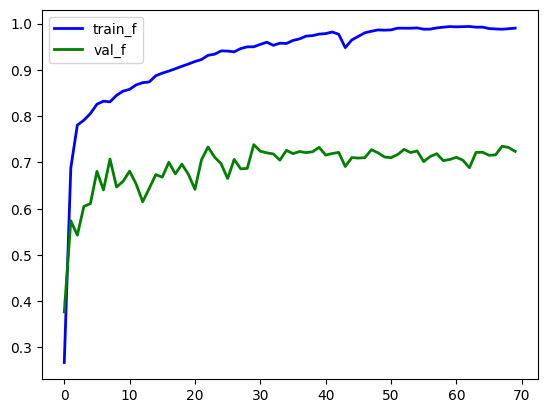

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'val_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'val_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()


In [21]:
%load_ext tensorboard

In [22]:
OUTPUT_PATH = "model_saves/bilstmtagger"

In [23]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(8711, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=6, bias=True)
)

In [24]:
labels = label_field.vocab.itos[2:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

              precision    recall  f1-score   support

        B-AC       0.58      0.69      0.63       270
        I-LF       0.65      0.81      0.72       288
        B-LF       0.56      0.63      0.59       150
         B-O       0.97      0.93      0.95      4292

    accuracy                           0.91      5000
   macro avg       0.69      0.76      0.72      5000
weighted avg       0.91      0.91      0.91      5000



In [25]:
from colorama import Back, Style

def vizu(words, output, truth):
    if isinstance(output, torch.Tensor):
        output = output.squeeze().tolist()
    col = {0: Back.GREEN, 1: Back.RED, 2: Back.BLACK, 3: Back.BLUE, 4: Back.MAGENTA}
    colors1 = [col[i] for i in output]
    colors2 = [col[i] for i in truth]
    words = [word.replace("Ġ", "") for word in words]
    print(Style.RESET_ALL + "Output:")
    for i, word in enumerate(words):
        print(colors1[i] + word, end=" ")
    print(Style.RESET_ALL + "\nTruth:")
    for i, word in enumerate(words):
        print(colors2[i] + word, end=" ")